In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.time import parse_time
from astropy.io import fits
from astropy.time import Time
import math
import os
import shutil
import datetime
from sklearn import preprocessing

from utils import *

In [2]:
pd.options.display.max_columns = None

In [3]:
AIA_DATA_DIR = '../../MVTS_data_preparation/data'
EVENTS_BY_DATE_DIR = './events_by_date'
EVENTS_BY_CLASS_DIR = './events_by_class'

TRAIN_DATA_POSITIVE_DIR = './data/train/positive'
TRAIN_DATA_NEGATIVE_DIR = './data/train/negative'
TEST_DATA_POSITIVE_DIR = './data/test/positive'
TEST_DATA_NEGATIVE_DIR = './data/test/negative'
VAL_DATA_POSITIVE_DIR = './data/val/positive'
VAL_DATA_NEGATIVE_DIR = './data/val/negative'

LSTM_TRAIN_DATA_POSITIVE_DIR = './lstm_data/train/positive'
LSTM_TRAIN_DATA_NEGATIVE_DIR = './lstm_data/train/negative'
LSTM_TEST_DATA_POSITIVE_DIR = './lstm_data/test/positive'
LSTM_TEST_DATA_NEGATIVE_DIR = './lstm_data/test/negative'
LSTM_VAL_DATA_POSITIVE_DIR = './lstm_data/val/positive'
LSTM_VAL_DATA_NEGATIVE_DIR = './lstm_data/val/negative'

In [4]:
CDELT = 0.599733;
HPCCENTER = 4096.0 / 2.0;
rsun_meters = 696000;
dsun_meters = 149600000;
DEFAULT_WIDTH, DEFAULT_HEIGHT = 64, 64
IMAGE_WIDTH, IMAGE_HEIGHT = 512, 512

In [5]:
def delete_files(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [6]:
def delete_data():
    delete_files(TRAIN_DATA_POSITIVE_DIR)
    delete_files(TRAIN_DATA_NEGATIVE_DIR)
    delete_files(TEST_DATA_POSITIVE_DIR)
    delete_files(TEST_DATA_NEGATIVE_DIR)
    delete_files(VAL_DATA_POSITIVE_DIR)
    delete_files(VAL_DATA_NEGATIVE_DIR)

In [7]:
def delete_lstm_data():
    delete_files(LSTM_TRAIN_DATA_POSITIVE_DIR)
    delete_files(LSTM_TRAIN_DATA_NEGATIVE_DIR)
    delete_files(LSTM_TEST_DATA_POSITIVE_DIR)
    delete_files(LSTM_TEST_DATA_NEGATIVE_DIR)
    delete_files(LSTM_VAL_DATA_POSITIVE_DIR)
    delete_files(LSTM_VAL_DATA_NEGATIVE_DIR)

In [8]:
def GetAIAFormatFilename(dt):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    AIA_data_time = f'{dt.hour:02d}{dt.minute:02d}'
    AIA_data_filename = f'AIA{AIA_data_date}_{AIA_data_time}_0094'
    
    return AIA_data_filename

In [9]:
# returns a formatted file name of the closest AIA data file to the given datetime

def GetClosestDataFileByDate(dt, rounding):
    AIA_data_date = f'{dt.year}{dt.month:02d}{dt.day:02d}'
    tmp_dt = dt
    minute = 0
    
    if(rounding == "down"):
        minute = GetClosestMultipleDown(tmp_dt.minute, 6)
    elif(rounding == "up"):
        minute = GetClosestMultipleUp(tmp_dt.minute, 6)
    
    if(minute == 60):
        tmp_dt = tmp_dt + datetime.timedelta(hours=1)
        minute = 0
    
    AIA_data_time = f'{tmp_dt.hour:02d}{minute:02d}'
    AIA_data_filename = f'AIA{AIA_data_date}_{AIA_data_time}_0094.npz'
    
    return AIA_data_filename

In [10]:
# returns an NxN cutout of an AIA image array centered around the given coordinate

def GetCutout(im, coord, N=64):
    x_end_idx = int(coord[0]+N)
    y_end_idx = int(coord[1]+N)
    cutout_array = im[int(coord[0]):x_end_idx, int(coord[1]):y_end_idx]
    
    return cutout_array

In [11]:
# returns an NxN cutout of a file centered around the given coordinate

def GetFileCutout(path, coord, N=64):
    im = np.load(path)['x']
    
    return GetCutout(im, coord, N)

In [12]:
# returns an AIA filepath closest to the provided

def GetAIAPathAtTime(dt):
    dt_data_dir = os.path.join(AIA_DATA_DIR, f'{dt.year}/{dt.month:02d}/{dt.day:02d}')
    closest_data_file = GetClosestDataFileByDate(dt, "up")
    file_path = os.path.join(dt_data_dir, closest_data_file)
    if not os.path.exists(file_path):
        raise FileNotFoundError
    
    return file_path

In [13]:
# returns M consecutive (forward or backward) AIA filepaths starting at time closest to the given time

def GetAIANCutoutsPaths(start_dt, direction='backward', M=6, cadence=6):
    cutouts_paths = []
    if direction == 'backward':
        cadence = -cadence
    dynamic_dt = start_dt
        
    for i in range(M):
        try:
            cutout_path = GetAIAPathAtTime(dynamic_dt)
        except FileNotFoundError:
            dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
            continue
        cutouts_paths.append(cutout_path)
        dynamic_dt = dynamic_dt + datetime.timedelta(minutes=cadence)
    
    cutouts_paths = sorted(cutouts_paths)
    num_paths = len(cutouts_paths)
    filled_paths = cutouts_paths

    if num_paths != M:
        # print(f'filling files, start_dt: {start_dt} num_paths: {num_paths} len filled_paths: {len(filled_paths)}')
        diff = abs(M-num_paths)
        # print(f'diff: {diff} num-diff: {num_paths-diff}')
        for i in range(num_paths, num_paths-diff, -1):
            filled_paths.insert(i-1, filled_paths[i-1])
            # print(f'inserted {filled_paths[i-1]} at pos {i-1}')
        filled_paths = sorted(filled_paths)
        # print(f'after filling: {np.array(filled_paths)}')
    filled_paths = sorted(filled_paths)
    return np.array(filled_paths)

In [14]:
# saves directional sequences of NxN cutouts of all events in the csv file to folders with start times as names

def SaveAIANCutoutsFromDF(df, save_dir, time_delta, num_frames=1, direction='backward', flare_class='all'):
    nonexistent = 0
    for index, row in df.iterrows():
        raw_time, goes_cls = parse_time(row['event_starttime'], precision=0), row['fl_goescls'][0]
        if flare_class != 'all':
            if goes_cls != flare_class:
                continue
        start_dt, y, x = raw_time.datetime, int(row['hpc_x']), int(row['hpc_y'])
        prior_dt = start_dt + datetime.timedelta(minutes=time_delta)
        coord = ConvertHPCToPixXY((x, y))
        coord = ResizeCoord(coord)
        coord = (coord[0]-32, 512-coord[1]-32)
        
        closest_file_name = GetClosestDataFileByDate(prior_dt, rounding='up')
        closest_file_path = f'{AIA_DATA_DIR}/{prior_dt.year}/{prior_dt.month:02}/{prior_dt.day:02}/{closest_file_name}'

        if not os.path.exists(closest_file_path):
            nonexistent+=1
            continue
        
        paths = GetAIANCutoutsPaths(prior_dt, direction='backward', M=num_frames, cadence=6)
        if len(paths) != 6:
            print(start_dt)
            print(len_dt)
        mod_save_dir = save_dir
        
        if len(paths) > 1:
            folder_name = GetAIAFormatFilename(start_dt)
            event_folder_path = os.path.join(save_dir, folder_name)
            if not os.path.exists(event_folder_path):
                os.makedirs(event_folder_path)
            else:
                print(f'trying to create existing folder, time: {start_dt}')
                continue 
            mod_save_dir = event_folder_path
        for idx, p in enumerate(paths):
            cutout = GetFileCutout(p, coord)
            save_filename = os.path.basename(p).rsplit('.', 1)[0]
            np.save(f'{mod_save_dir}/{save_filename}_{idx}', cutout)
    # print(f'{nonexistent} files did not exist')

In [15]:
def CreateTrainTestValData(test_split=0.1, val_split=0.1, classes='all'):
    delete_data()
    train_split = 1-test_split+val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateTrainTestValDataOfClass(class_df, test_split, val_split, classes)

In [16]:
def CreateLSTMData(test_split=0.1, val_split=0.1, classes='all'):
    delete_lstm_data()
    train_split = 1-test_split+val_split
    
    for subdir, dirs, files in os.walk(EVENTS_BY_CLASS_DIR):
        for file in files:
            if classes != 'all':
                if file.rsplit('.', 1)[0] != classes:
                    continue
            print(file.rsplit('.', 1)[0])
            class_df = pd.read_csv(os.path.join(subdir, file))
            CreateLSTMDataOfClass(class_df, test_split, val_split, classes)

In [17]:
def CreateTrainTestValDataOfClass(class_df, test_split, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    test_split_num, val_split_num = math.ceil(event_num*test_split), math.ceil(event_num*val_split)
    test_df = class_df[-test_split_num:]
    class_df = class_df[:-test_split_num]
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = -6
    random_time_delta = 6 * time_delta
    
    SaveAIANCutoutsFromDF(test_df, TEST_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(test_df, TEST_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(val_df, VAL_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(val_df, VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(class_df, TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=1, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(class_df, TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=1, direction='backward', flare_class=classes)
    
    # print(f'total training data: {len(train_df)*2}, total val data: {len(val_df)*2}, total test data: {len(test_df)*2}')

In [18]:
def CreateLSTMDataOfClass(class_df, test_split, val_split, classes='all'):
    class_df = class_df.sample(frac=1).reset_index(drop=True)
    event_num = len(class_df)
    test_split_num, val_split_num = math.ceil(event_num*test_split), math.ceil(event_num*val_split)
    test_df = class_df[-test_split_num:]
    class_df = class_df[:-test_split_num]
    val_df = class_df[-val_split_num:]
    class_df = class_df[:-val_split_num]
    time_delta = -6
    random_mult = np.random.randint(3, 7)
    random_time_delta = random_mult * time_delta
    
    SaveAIANCutoutsFromDF(test_df, LSTM_TEST_DATA_POSITIVE_DIR, time_delta, num_frames=6, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(test_df, LSTM_TEST_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(val_df, LSTM_VAL_DATA_POSITIVE_DIR, time_delta, num_frames=6, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(val_df, LSTM_VAL_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, direction='backward', flare_class=classes)
    
    SaveAIANCutoutsFromDF(class_df, LSTM_TRAIN_DATA_POSITIVE_DIR, time_delta, num_frames=6, direction='backward', flare_class=classes)
    SaveAIANCutoutsFromDF(class_df, LSTM_TRAIN_DATA_NEGATIVE_DIR, random_time_delta, num_frames=6, direction='backward', flare_class=classes)

In [19]:
# CreateTrainTestValData(classes='B')

In [20]:
CreateLSTMData(classes='B')

B
trying to create existing folder, time: 2010-11-13 17:04:00
trying to create existing folder, time: 2010-11-05 23:26:00
trying to create existing folder, time: 2010-11-13 17:04:00
trying to create existing folder, time: 2010-11-05 23:26:00


In [21]:
data_folder = './lstm_data/val/positive/AIA20100930_0944_0094'
paths = []
for subdir, dirs, files in os.walk(data_folder):
    for f in files:
        paths.append(os.path.join(subdir, f))
paths = sorted(paths, reverse=True)

In [22]:
paths

[]

IndexError: list index out of range

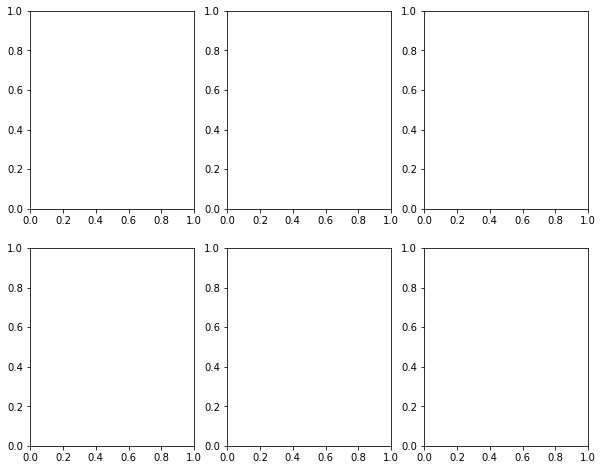

In [23]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
# data_choice = np.random.choice(range(len(x_train)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(np.load(paths[idx])))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
plt.show()

In [ ]:
total_train_data = 0
total_test_data = 0
total_val_data = 0

for subdir, dirs, files in os.walk(TRAIN_DATA_POSITIVE_DIR):
    total_train_data += len(files)
    
for subdir, dirs, files in os.walk(TRAIN_DATA_NEGATIVE_DIR):
    total_train_data += len(files)
    
for subdir, dirs, files in os.walk(TEST_DATA_POSITIVE_DIR):
    total_test_data += len(files)
    
for subdir, dirs, files in os.walk(TEST_DATA_NEGATIVE_DIR):
    total_test_data += len(files)
    
for subdir, dirs, files in os.walk(VAL_DATA_POSITIVE_DIR):
    total_val_data += len(files)
    
for subdir, dirs, files in os.walk(VAL_DATA_NEGATIVE_DIR):
    total_val_data += len(files)
    
print(f'train data: {total_train_data} val data: {total_val_data} test data: {total_test_data}')

In [ ]:
t = np.load('./data/train/positive/AIA20100928_2106_0094.npy')

In [ ]:
plt.imshow(t)

In [ ]:
# for year in range(2010, 2018):
#     for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
#         for f in files:
#             fulldir = os.path.join(subdir, f)
#             SaveAIANPositiveCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/B/positive', direction='backward', flare_class='B')

#     for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
#         for f in files:
#             fulldir = os.path.join(subdir, f)
#             SaveAIANNegativeCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/B/negative', direction='backward', flare_class='B')

In [ ]:
# for year in range(2010, 2018):
#     for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
#         for f in files:
#             fulldir = os.path.join(subdir, f)
#             SaveAIANPositiveCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/train/positive', direction='backward', flare_class='all')

#     for subdir, dirs, files in os.walk(f'{EVENTS_BY_DATE_DIR}/{year}'):
#         for f in files:
#             fulldir = os.path.join(subdir, f)
#             SaveAIANNegativeCutoutsFromCSV(fulldir, './LSTM_data/flare_start_prediction/train/negative', direction='backward', flare_class='all')